# Statische Systemidentifikation mit CasADi

In [4]:
import casadi as cs
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

Gegeben seien Messdaten eines technischen Prozesses mit zwei Eingangssignalen $u_{1}$,$u_{2}$ und einem Ausgangssignal $y_{1}$

In [5]:
data = pkl.load(open('./data/static_data.pkl','rb'))

Text(0.5, 0, 'y')

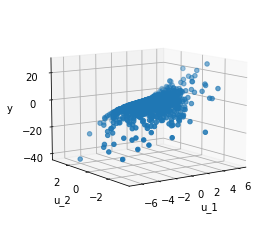

In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.elev = 10 # Höhe der Betrachung
ax.azim = 235 # Neigungswinkel der Betrachtung
ax.scatter(data['u1'],data['u2'],data['y'])

ax.set_xlabel('u_1')
ax.set_ylabel('u_2')
ax.set_zlabel('y')

Als Modellierungsansatz wird ein statisches polynomiales Modell gewählt:
$y_{k}=\theta_{1} u_{1,k}^3 + \theta_{2} u_{1,k}^2 + \theta_{3} u_{1,k} + \theta_{4} u_{2,k}^3 + \theta_{5} u_{2,k}^2 + \theta_{6} u_{2,k}$

In [7]:
theta = cs.MX.sym('theta',6,1)

u = cs.MX.sym('u',2,1)
y = theta[0]*u[0]**3 + theta[1]*u[0]**2 + theta[2]*u[0] + theta[3]*u[1]**3 + theta[4]*u[1]**2 + theta[5]*u[1]

Die Modellgleichung kann bereits als CasADi-Funktion definiert werden:

In [8]:
f_model = cs.Function('f_model',[u,theta],[y],['u','theta'],['y'])

Anschließend muss die zu optimierende Funktion als CasADi-Funktion definiert werden. Ziel der Optimierung ist $\boldsymbol{\theta}$ so zu wählen, dass die Summe der Abweichungsquadrate $L = \frac{1}{2}\sum\limits_{k}^{N} (\hat{y}_{k}-y_{k})^2$ minimiert wird:

In [9]:
L = 0
for k in range(0,1000):
    u_k = data.loc[k][['u1','u2']].values.reshape((2,1))
    y_k = data.loc[k]['y']
    
    y_hat = f_model(u=u_k, theta=theta)['y']
    L = L + 0.5*(y_hat - y_k)**2
    

$L$ is nun ein CasADi-Ausdruck, der die Summe des quadratischen Prädiktionsfehlers in Abhängigkeit der Modellparameter $\boldsymbol{\theta}$ beinhaltet. Eine Abhängigkeit von den Eingangs- oder Ausgangssignalen $u_{1}$, $u_{2}$ und $y$ besteht nicht mehr, da diese bereits "eingesetzt" wurden. 

Anschließend können nun Jacobi-Matrix und Hesse-Matrix gebildet werden

In [10]:
L_jac = cs.jacobian(L,theta)
L_hess = cs.hessian(L,theta)[0]

und das gesamte Optimierungsproblem in eine CasADi-Funktion gekapselt werden:

In [11]:
opt = cs.Function('opt',[theta],[L,L_jac,L_hess],['theta'],['L','L_jac','L_hess'])

Die Kostenfunktion ist quadratisch, da der Modellansatz linear in den Parametern $\boldsymbol{\theta}$ ist ($\hat{y}=\sum\limits_{i}^{n}\theta_{i}u_{i}$): 

$\underset{\boldsymbol{\theta}}{\mathrm{minimize}} \qquad \frac{1}{2}\boldsymbol{\theta}^{T}\boldsymbol{H}\boldsymbol{\theta} + \boldsymbol{g}^{T}\boldsymbol{\theta}$


Das bedeutet die Lösung des Optimierungsproblems ist eindeutig (globales Optimum) und kann in einem einzigen Schritt ermittelt werden.

Casadi stellt ein Interface für quadratische Solver bereit: "conic" 

In [12]:
qp_struct = {}
qp_struct['h'] = L_hess.sparsity()

solver = cs.conic('solver','qpoases',qp_struct)

Der Solver wird aufgerufen, indem ein Startwert für die gesuchten Parameter übergeben wird:

In [13]:
theta_init = np.array([[2],[2],[2],[2],[2],[2]])
L_val,L_jac,L_hess = opt(theta_init)

result = solver(h=L_hess, g=L_jac)

d_theta = result['x']



#################   qpOASES  --  QP NO.   1   ##################

    Iter   |    StepLength    |       Info       |   nFX    
 ----------+------------------+------------------+--------- 
       0   |   0.000000e+000   |   REM BND    0   |     5   
       1   |   8.087058e-012   |   REM BND    1   |     4   
       2   |   1.423265e-011   |   REM BND    3   |     3   
       3   |   1.311948e-010   |   REM BND    4   |     2   
       4   |   1.292619e-010   |   REM BND    2   |     1   
       5   |   7.495392e-010   |   REM BND    5   |     0   
       6   |   1.000000e+000   |    QP SOLVED     |     0   


Die optimalen Parameter sind dann

In [14]:
theta_opt = theta_init + d_theta
print(theta_opt)

[0.1, -2.22045e-015, 1, -8.88178e-016, -1.8, -0.1]


Auswertung des Modells mit den optimierten Parametern auf den Trainingsdaten:

In [15]:
y_hat = []
for k in range(0,1000):
    u_k = data.loc[k][['u1','u2']].values.reshape((2,1))
    y_k = data.loc[k]['y']
    
    y_hat.append(float(f_model(u=u_k, theta=theta_opt)['y']))

data = data.assign(y_hat=y_hat)

Auswertung des Modells mit den optimalen Parametern auf den Messdaten

Text(0.5, 0, 'y')

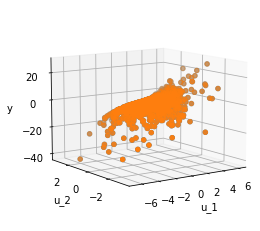

In [16]:
ax.scatter(data['u1'],data['u2'],data['y_hat'])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.elev = 10 # Höhe der Betrachung
ax.azim = 235 # Neigungswinkel der Betrachtung
ax.scatter(data['u1'],data['u2'],data['y'])
ax.scatter(data['u1'],data['u2'],data['y_hat'])

ax.set_xlabel('u_1')
ax.set_ylabel('u_2')
ax.set_zlabel('y')

Alternative High-Level Interface:

In [17]:
qp = {'x':theta, 'f':L}
S = cs.qpsol('S', 'qpoases', qp)
r=S()

r['x']



#################   qpOASES  --  QP NO.   1   ##################

    Iter   |    StepLength    |       Info       |   nFX    
 ----------+------------------+------------------+--------- 
       0   |   0.000000e+000   |   REM BND    0   |     5   
       1   |   8.087048e-012   |   REM BND    1   |     4   
       2   |   1.423264e-011   |   REM BND    3   |     3   
       3   |   1.311946e-010   |   REM BND    4   |     2   
       4   |   1.292618e-010   |   REM BND    2   |     1   
       5   |   7.495385e-010   |   REM BND    5   |     0   
       6   |   1.000000e+000   |    QP SOLVED     |     0   


DM([0.1, -4.68375e-016, 1, -7.41052e-017, -1.8, -0.1])